<a href="https://colab.research.google.com/github/AhmedRezaShams/Python/blob/main/HUzi_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import time

import numpy as np
import torch
import torch.nn.functional as F

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Hyperparameters
random_seed = 1
learning_rate = 0.001
num_epochs = 30
batch_size = 128

# Architecture
num_classes = 4

In [ ]:
!pip install -U -q PyDrive  #py framework
from pydrive.auth import GoogleAuth 
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client  import GoogleCredentials  #clint library
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
fid = drive.ListFile({'q':"title='fabric_defect.zip'"}).GetList()[0]['id'] #is a method call in the Google Drive API for Python that lists all the files in the current user's Google Drive that match a certain query.
f = drive.CreateFile({'id': fid})
f.GetContentFile('fabric_defect.zip')
f.keys()
!unzip fabric_defect.zip


Archive:  fabric_defect.zip
   creating: Fabric defect/
   creating: Fabric defect/test/
   creating: Fabric defect/test/hole/
  inflating: Fabric defect/test/hole/1.jpg  
  inflating: Fabric defect/test/hole/10.jpg  
  inflating: Fabric defect/test/hole/10_processed (1).jpg  
  inflating: Fabric defect/test/hole/10_processed (2).jpg  
  inflating: Fabric defect/test/hole/10_processed (3).jpg  
  inflating: Fabric defect/test/hole/11.jpg  
  inflating: Fabric defect/test/hole/11_processed (1).jpg  
  inflating: Fabric defect/test/hole/11_processed (2).jpg  
  inflating: Fabric defect/test/hole/11_processed (3).jpg  
  inflating: Fabric defect/test/hole/12.jpg  
  inflating: Fabric defect/test/hole/12_processed (1).jpg  
  inflating: Fabric defect/test/hole/12_processed (2).jpg  
  inflating: Fabric defect/test/hole/12_processed (3).jpg  
  inflating: Fabric defect/test/hole/13.jpg  
  inflating: Fabric defect/test/hole/13_processed (1).jpg  
  inflating: Fabric defect/test/hole/13_proc

In [ ]:
from torchvision import transforms

data_transforms = {
    "train": transforms.Compose(
        [
            transforms.Resize(32),
            transforms.RandomCrop((28, 28)),
            transforms.ToTensor(),
            # normalize images to [-1, 1] range
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    ),
    "test": transforms.Compose(
        [
            transforms.Resize(32),
            transforms.CenterCrop((28, 28)),
            transforms.ToTensor(),
            # normalize images to [-1, 1] range
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    ),
}

In [ ]:
from torch.utils.data.dataset import random_split
from torchvision.datasets import ImageFolder

train_dset = ImageFolder(root="/content/Fabric defect/train", transform=data_transforms["train"])
num_train_images = int(0.8 * len(train_dset))
train_dset, valid_dset = random_split(train_dset, lengths=[num_train_images, len(train_dset) - num_train_images])

test_dset = ImageFolder(root="/content/Fabric defect/test", transform=data_transforms["test"])

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    dataset=train_dset,
    batch_size=batch_size,
    drop_last=True,
    num_workers=4,
    shuffle=True,
)

valid_loader = DataLoader(
    dataset=valid_dset,
    batch_size=batch_size,
    drop_last=False,
    num_workers=4,
    shuffle=False,
)

test_loader = DataLoader(
    dataset=test_dset,
    batch_size=batch_size,
    drop_last=False,
    num_workers=4,
    shuffle=False,
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


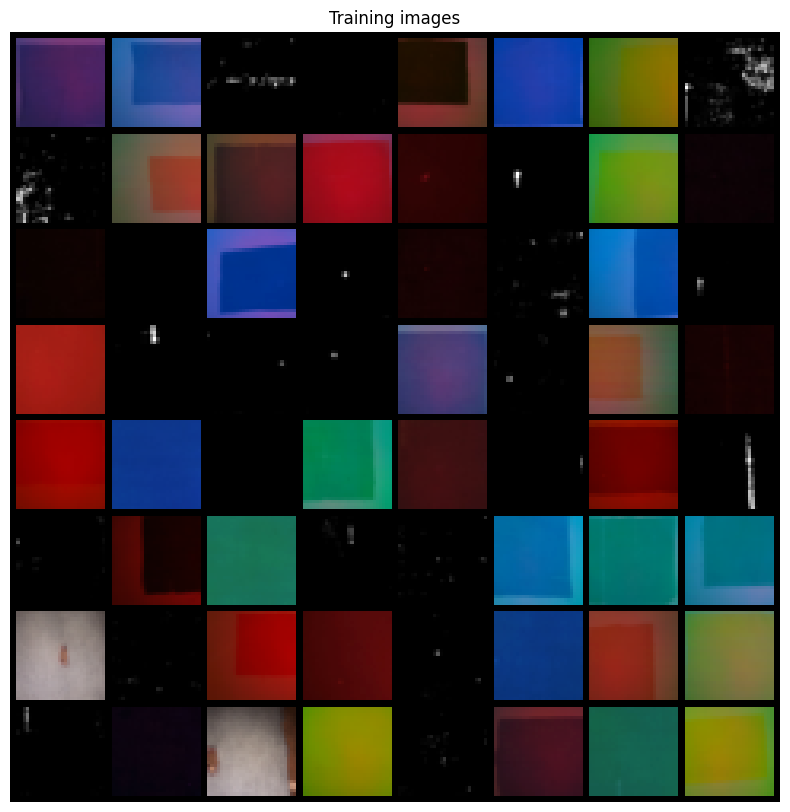

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import torchvision.utils as vutils

real_batch = next(iter(train_loader))
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.title("Training images")
plt.imshow(
    np.transpose(
        vutils.make_grid(real_batch[0][:64], padding=2, normalize=True), (1, 2, 0)
    )
)
plt.show()

In [ ]:
import torch


class PyTorchCNN(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.num_classes = num_classes
        self.features = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=3,
                out_channels=8,
                kernel_size=(3, 3),
                stride=(1, 1),
                padding=1,
            ),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0),
            torch.nn.ReLU(),
            torch.nn.Conv2d(
                in_channels=8,
                out_channels=16,
                kernel_size=(3, 3),
                stride=(1, 1),
                padding=1,
            ),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0),
        )

        self.classifier = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(784, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


torch.manual_seed(random_seed)
model = PyTorchCNN(num_classes=num_classes)
model = model.to(device)

In [ ]:
def compute_accuracy(model, data_loader, device):
    with torch.no_grad():
        correct_pred, num_examples = 0, 0
        for features, targets in data_loader:
            features, targets = features.to(device), targets.to(device)
            logits = model(features)
            _, predicted_labels = torch.max(logits, 1)
            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
        return correct_pred.float() / num_examples
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

start_time = time.time()
for epoch in range(num_epochs):
    model = model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):

        features, targets = features.to(device), targets.to(device)

        ### Forward pass
        logits = model(features)
        loss = F.cross_entropy(logits, targets)

        ### Backward pass (backpropagation)
        optimizer.zero_grad()
        loss.backward()

        ### Update model parameters
        optimizer.step()

        ### Batch-level logging
        if not (batch_idx + 1) % 100:
            print(
                f"Epoch: {epoch + 1:03d}/{num_epochs:03d} | "
                f"Batch: {batch_idx + 1:03d}/{len(train_loader):03d} | "
                f"Loss: {loss:.4f}"
            )

    ### Epoch-level logging
    model = model.eval()
    train_acc = compute_accuracy(model, train_loader, device)
    valid_acc = compute_accuracy(model, valid_loader, device)
    print(
        f"Training accuracy: {train_acc * 100:.2f}% | "
        f"Validation accuracy: {valid_acc * 100:.2f}%"
    )
    print(f"Time elapsed: {(time.time() - start_time) / 60:.2f} min")

print(f"Total training time: {(time.time() - start_time) / 60:.2f} min")

Training accuracy: 43.55% | Validation accuracy: 37.31%
Time elapsed: 0.81 min
Training accuracy: 42.97% | Validation accuracy: 37.31%
Time elapsed: 1.41 min
Training accuracy: 43.75% | Validation accuracy: 37.31%
Time elapsed: 1.91 min
Training accuracy: 43.16% | Validation accuracy: 37.31%
Time elapsed: 2.44 min
Training accuracy: 43.55% | Validation accuracy: 36.57%
Time elapsed: 2.95 min
Training accuracy: 45.12% | Validation accuracy: 38.06%
Time elapsed: 3.45 min
Training accuracy: 46.09% | Validation accuracy: 38.06%
Time elapsed: 3.95 min
Training accuracy: 46.09% | Validation accuracy: 39.55%
Time elapsed: 4.46 min
Training accuracy: 46.09% | Validation accuracy: 41.04%
Time elapsed: 4.98 min
Training accuracy: 48.24% | Validation accuracy: 42.54%
Time elapsed: 5.48 min
Training accuracy: 48.24% | Validation accuracy: 44.03%
Time elapsed: 5.98 min
Training accuracy: 49.80% | Validation accuracy: 44.03%
Time elapsed: 6.49 min
Training accuracy: 49.41% | Validation accuracy: 42.

In [ ]:
test_acc = compute_accuracy(model, test_loader, device)
print(f"Test accuracy: {test_acc*100:.2f}%")

Test accuracy: 55.71%


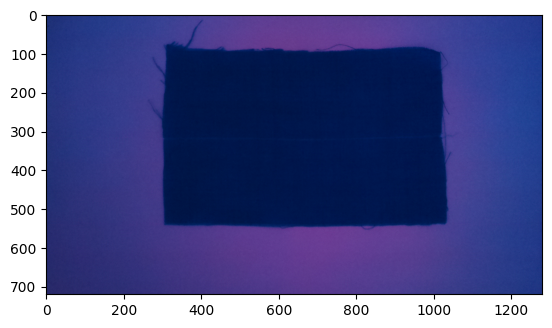

In [ ]:
import matplotlib.image as mpimg

img_path = "/content/Fabric defect/test/Lines/line_2018-09-19 15_19_10.492631.jpg"
img = plt.imread(img_path)
plt.imshow(img)
plt.show()